# DynoMTGBM (-logkm logkcat logkcatkm)

In [1]:
import os
import json
import torch
import random
import pandas as pd
from decorator import append
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr
import numpy as np
from copy import deepcopy
import lightgbmmt as lgb
current_dir = os.getcwd()


def return_mtgbm_x_y(df_data, tasks):
    y = np.array(df_data[tasks].values)

    auxiliary_data = []
    if use_t_ph_embedding:
        ph = df_data['ph'].values.reshape(-1, 1)
        t = df_data['t'].values.reshape(-1, 1)
        auxiliary_data.append(ph)
        auxiliary_data.append(t)

    if use_mw_logp:
        mw = df_data['mw'].values.reshape(-1, 1)
        logp = df_data['logp'].values.reshape(-1, 1)
        auxiliary_data.append(mw)
        auxiliary_data.append(logp)

    protein_data = np.array(df_data[protein_column].tolist())
    substrate_data = np.array(df_data[substrate_column].tolist())

    x = np.hstack([protein_data, substrate_data] + auxiliary_data)
    return x, y

def return_scores(y_true, y_pred):
    mask = y_true != fill_nan_value
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    pcc = pearsonr(y_true, y_pred)[0]

    return rmse, mae, r2, pcc

def print_scores(task_scores_dict):
    for task_name in task_names:
        print(f"{task_name}\t RMSE\t MAE\t R2\t PCC\t")

        task_val_scores = task_scores_dict[task_name]['val']
        task_test_scores = task_scores_dict[task_name]['test']

        val_metrics = [f"{np.mean(task_val_scores[metric_name]):.4f}\t" for metric_name in
                       score_names]
        print("Val  " + " ".join(val_metrics))

        test_metrics = [f"{np.mean(task_test_scores[metric_name]):.4f}\t" for metric_name in
                        score_names]
        print("Test " + " ".join(test_metrics))
        print()


def cal_grad(preds, train_data, ep=0):
    labels = torch.tensor(train_data.get_label(), device=device)
    preds = torch.tensor(preds, device=device)
    labels = labels.view(num_tasks, -1).T
    preds = preds.view(num_tasks, -1).T

    # mask
    valid_mask = labels != fill_nan_value
    grad = torch.zeros_like(preds)
    grad[valid_mask] = preds[valid_mask] - labels[valid_mask]

    # sum
    grad_final = grad.mean(dim=1)

    # Hessian
    grad_flattened = grad.T.flatten()
    hess = torch.ones_like(grad_final)
    hess2 = torch.ones_like(grad_flattened)

    return grad_final.cpu().numpy(), hess.cpu().numpy(), grad_flattened.cpu().numpy(), hess2.cpu().numpy()

# TODO Train model
def train_mtgbm(params):
    def self_kcat_rmse(preds, train_data):
        labels = torch.tensor(train_data.get_label(), device=device)
        preds = torch.tensor(preds, device=device)
        labels = labels.view(num_tasks, -1).T
        preds = preds.view(num_tasks, -1).T

        # all task rmse
        task_rmse = []
        for task_idx in range(num_tasks):
            valid_mask = labels[:, task_idx] != fill_nan_value
            rmse_value = torch.sqrt(torch.mean((labels[:, task_idx][valid_mask] - preds[:, task_idx][valid_mask]) ** 2))
            task_rmse.append(rmse_value.item())

        if record:
            if labels.shape[0] < 10000:
                log_folds_records['valid'][-1].append(task_rmse)
            else:
                log_folds_records['train'][-1].append(task_rmse)

        return 'rmse_kcat', task_rmse[-2], False

    temp_params = deepcopy(params)
    temp_params.update({"verbosity": -1, "objective": "custom", "num_labels": num_tasks, "tree_learner": 'serial2', "num_threads": num_threads})
    num_iterations = temp_params.pop("num_iterations")
    task_scores_dict = {task_name: {'val': {name: [] for name in score_names}, 'test': {name: [] for name in score_names}} for task_name in task_names}

    for fold_idx, (train_index, val_index) in enumerate(kf.split(train_val_x), start=1):
        print(f"Fold {fold_idx}")
        # split dataset
        train_x, val_x = train_val_x[train_index], train_val_x[val_index]
        train_y, val_y = train_val_y[train_index], train_val_y[val_index]
        train_data = lgb.Dataset(train_x, label=train_y)
        val_data = lgb.Dataset(val_x, label=val_y)

        # get the best epoch number
        evals_result_mt = {}
        record = True
        log_folds_records['train'].append([])
        log_folds_records['valid'].append([])
        lgb.train(temp_params, train_data, num_iterations, valid_sets=[train_data, val_data],
                  fobj=cal_grad, feval=self_kcat_rmse, verbose_eval=300, evals_result=evals_result_mt,
                  callbacks=[lgb.early_stopping(stopping_rounds=500)])

        # train_records = evals_result_mt['training']['rmse_kcat']
        valid_records = evals_result_mt['valid_1']['rmse_kcat']
        min_index = np.argmin(np.array(valid_records))
        print(f"valid_records min_index {min_index}")

        # train model for all scores of validation and test
        train_data = lgb.Dataset(train_x, label=train_y)
        val_data = lgb.Dataset(val_x, label=val_y)
        evals_result_mt = {}
        record = False
        model = lgb.train(temp_params, train_data, min_index + 1, valid_sets=[val_data],
                          fobj=cal_grad, feval=self_kcat_rmse, verbose_eval=1000,
                          evals_result=evals_result_mt)
        model.set_num_labels(num_tasks)

        # validation predict
        val_predicted = model.predict(val_x)
        val_scores = {task_name: return_scores(val_y[:, idx], val_predicted[:, idx]) for idx, task_name in
                      enumerate(task_names)}

        # test predict
        test_predicted = model.predict(test_x)
        test_pred_list.append(test_predicted)
        test_scores = {task_name: return_scores(test_y[:, idx], test_predicted[:, idx]) for idx, task_name in
                       enumerate(task_names)}

        # record
        for task_name in task_names:
            for score_idx, score_name in enumerate(score_names):
                task_scores_dict[task_name]['val'][score_name].append(val_scores[task_name][score_idx])
                task_scores_dict[task_name]['test'][score_name].append(test_scores[task_name][score_idx])
        print(f"Val  {val_scores} \n Test {test_scores}\n")

    print_scores(task_scores_dict)


# init seed
random_state = 66
random.seed(random_state)
np.random.seed(random_state)
torch.manual_seed(random_state)
torch.cuda.manual_seed(random_state)
torch.cuda.manual_seed_all(random_state)

# config
protein_column,  substrate_column = 'prott5', 'molebert'
input_model = 'mtgbm_km_kcat_kcatkm'
dataset_path = f'{current_dir}/../../data_process/dataset/df_all_log_transformed.pkl'
use_t_ph_embedding = True
use_mw_logp = True
num_threads = 32
search_max_evals = 60
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Current device is {device}")

# input
score_names = ['rmse', 'mae', 'r2', 'pcc']
task_names = ['logkm', 'logkcat', 'logkcatkm']
num_tasks = len(task_names)
df_input = pd.read_pickle(dataset_path)
df_input['logkm'] = -df_input['logkm']
fill_nan_value = -100
df_input = df_input.fillna(fill_nan_value)

# split dataset
df_train_val, df_test = train_test_split(df_input, test_size=0.2, random_state=random_state)
kf = KFold(n_splits=5, shuffle=True, random_state=random_state)
train_val_x, train_val_y = return_mtgbm_x_y(df_train_val, task_names)
test_x, test_y = return_mtgbm_x_y(df_test, task_names)

with open(f'{current_dir}/../../kcatkm_mtgbm_ablation/{input_model}_params.json', 'r') as json_file:
    best_params = json.load(json_file)

print('best_params:', best_params)
print('using -km kcat kcatkm resample')
test_pred_list = []
log_folds_records = {'train':[], 'valid':[]}
record = True
train_mtgbm(best_params)
np.save(f'{current_dir}/results/dynomtgbm_test_pred.npy', np.array(test_pred_list))
np.save(f'{current_dir}/results/dynomtgbm_test_y.npy', np.array(test_y))

Current device is cuda:0
best_params: {'bagging_fraction': 0.729611058732434, 'feature_fraction': 0.6643005188332146, 'lambda_l1': 0.346846951564011, 'lambda_l2': 0.7149783548509333, 'learning_rate': 0.07838547411322133, 'max_bin': 95, 'max_depth': 9, 'min_data_in_leaf': 21, 'num_iterations': 3273, 'num_leaves': 2350}
using -km kcat kcatkm resample
Fold 1
Training until validation scores don't improve for 500 rounds
[300]	training's rmse_kcat: 1.7034	valid_1's rmse_kcat: 2.35919
[600]	training's rmse_kcat: 1.42501	valid_1's rmse_kcat: 2.24916
[900]	training's rmse_kcat: 1.27063	valid_1's rmse_kcat: 2.20112
[1200]	training's rmse_kcat: 1.17077	valid_1's rmse_kcat: 2.17887
[1500]	training's rmse_kcat: 1.09578	valid_1's rmse_kcat: 2.16325
[1800]	training's rmse_kcat: 1.0363	valid_1's rmse_kcat: 2.15454
[2100]	training's rmse_kcat: 0.990279	valid_1's rmse_kcat: 2.14849
[2400]	training's rmse_kcat: 0.9555	valid_1's rmse_kcat: 2.14437
[2700]	training's rmse_kcat: 0.931767	valid_1's rmse_kcat

In [2]:
pd.DataFrame(log_folds_records).to_pickle(f'./results/{input_model}_log_folds_records.pkl')

In [3]:
test = pd.read_pickle(f'./results/{input_model}_log_folds_records.pkl')
test.head()

,train,valid
0,"[[3.238668498907234, 3.615017991223926, 4.5196...","[[3.211046882734458, 3.6421311984329554, 4.652..."
1,"[[3.223789962832464, 3.6280693656686585, 4.542...","[[3.2849412177944273, 3.6239928922602758, 4.56..."
2,"[[3.2327120294597957, 3.6145188273317745, 4.54...","[[3.229516799556285, 3.6601147078377916, 4.562..."
3,"[[3.2313302748063673, 3.6354637475101024, 4.55...","[[3.243873781512792, 3.58673508904116, 4.53091..."
4,"[[3.2310817759465587, 3.6192174129252543, 4.55...","[[3.208834011383368, 3.643925727497849, 4.4921..."


In [4]:
np.array(test['train'][0]).shape
np.array(test['valid'][0])[-1, -1]

2.666788989521214

# Plot Loss

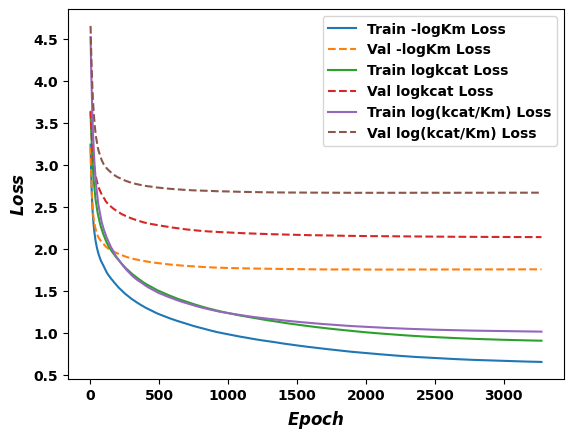

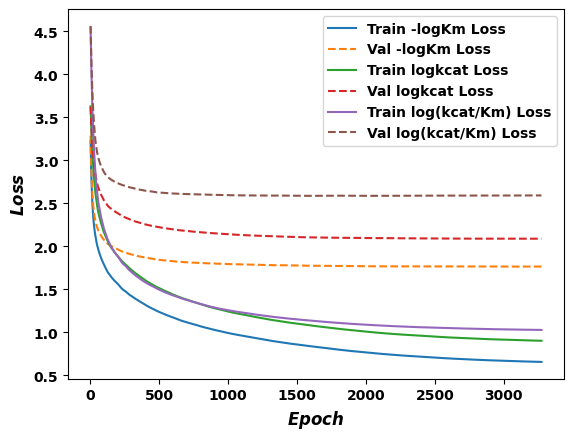

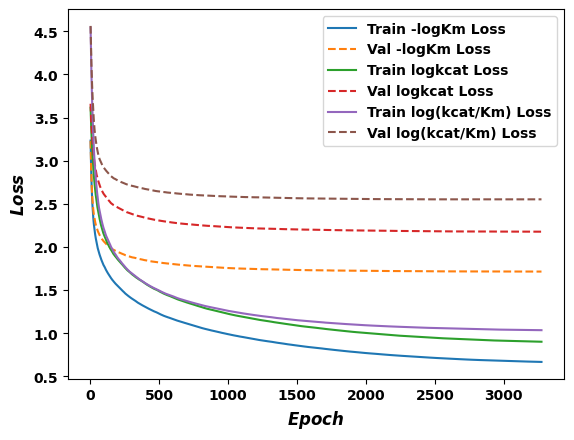

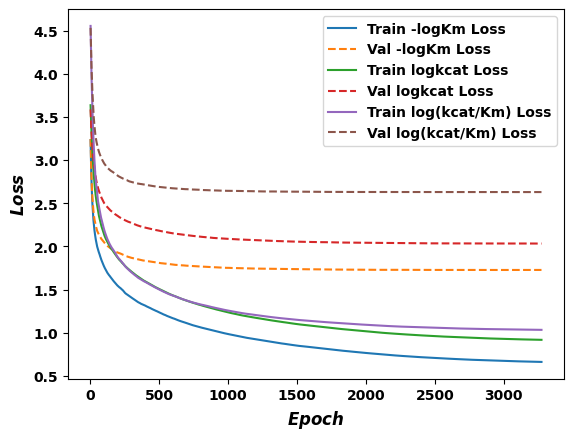

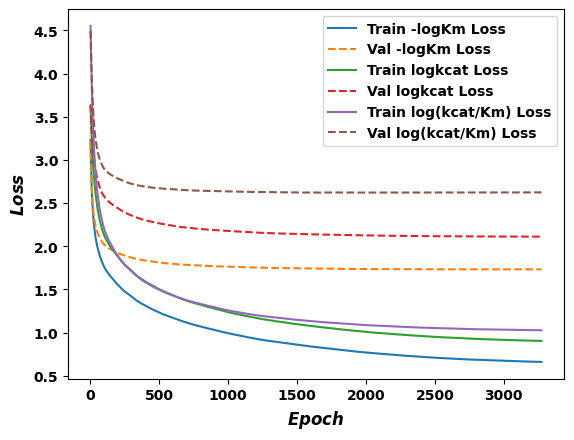

In [5]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc("font", weight="bold")

train_losses, val_losses = log_folds_records['train'], log_folds_records['valid']
for fold_idx in range(5):
    # plot
    plt.figure()
    epochs = range(1, len(train_losses[fold_idx]) + 1)
    train_loss = np.array(train_losses[fold_idx])
    val_loss = np.array(val_losses[fold_idx])
    for name_idx, name in enumerate(['-logKm', 'logkcat', 'log(kcat/Km)']):
        plt.plot(epochs, train_loss[:, name_idx], label=f'Train {name} Loss')
        plt.plot(epochs, val_loss[:, name_idx], label=f'Val {name} Loss', linestyle='--')

    plt.xlabel('$Epoch$', fontsize=12)
    plt.ylabel('$Loss$', fontsize=12)
    # plt.title(f'Training and Validation Loss per Epoch Cross Validation {fold_idx}')
    plt.legend()
    plt.savefig(current_dir + f'/results/{input_model}_loss_plot_cv{fold_idx}.png')  # 保存图表为图片文件
    plt.show()

# Calculate the mean value of predicted log(kcat) of 5 folds on test dataset

In [6]:
import numpy as np
import os
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr

def return_scores(y_true, y_pred):
    mask = y_true != fill_nan_value
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    pcc = pearsonr(y_true, y_pred)[0]

    return rmse, mae, r2, pcc

current_dir = os.getcwd()
fill_nan_value = -100
test_pred_list = np.load(f'{current_dir}/results/dynomtgbm_test_pred.npy')
test_pred_npy = np.array([np.array(_) for _ in test_pred_list])
logkcat_pred_mean = test_pred_npy[:, :, 1].mean(axis=0)

test_label_list = np.load(f'{current_dir}/results/dynomtgbm_test_y.npy')
logkcat_test_y = test_label_list[:, 1]
logkcat_scores = return_scores(logkcat_test_y, logkcat_pred_mean)
logkcat_scores

(2.08234037818463, 1.4238560798028563, 0.6639998555449647, 0.8152372061996831)

/tmp/ipykernel_671026/2201920379.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


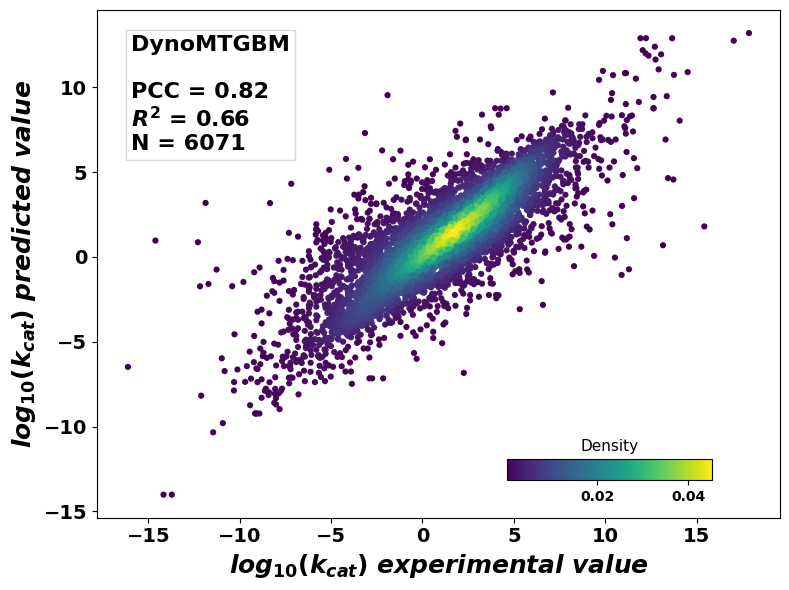

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, gaussian_kde
import matplotlib
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
matplotlib.rc("font", weight="bold")

# 过滤掉填充值
mask = logkcat_test_y != fill_nan_value
logkcat_test_y = logkcat_test_y[mask]
logkcat_pred_mean = logkcat_pred_mean[mask]
n = len(logkcat_test_y)

# 计算密度
xy = np.vstack([logkcat_test_y, logkcat_pred_mean])
z = gaussian_kde(xy)(xy)
fig, ax = plt.subplots(figsize=(8, 6))

sc = ax.scatter(
    logkcat_test_y,
    logkcat_pred_mean,
    c=z,
    s=20,
    cmap='viridis',
    linewidths=0
)

# 在图内底部居中插入一个横向 colorbar
cax = inset_axes(
    ax,
    width="60%",        # 控制宽度百分比
    height="4%",        # 控制高度
    loc='lower center', # 放在图的内部底部中间
    bbox_to_anchor=(0.5, 0.02, 0.5, 1),  # 精细控制位置偏移（可选）
    bbox_transform=ax.transAxes,
    borderpad=2
)

cb = plt.colorbar(sc, cax=cax, orientation='horizontal')
cb.ax.tick_params(labelsize=10)
cb.set_label('Density', fontsize=11, labelpad=6)
cb.ax.xaxis.set_label_position('top')

ax.set_xlabel(r'$log_{10}(k_{cat})$ $experimental$ $value$', fontsize=18)
ax.set_ylabel(r'$log_{10}(k_{cat})$ $predicted$ $value$', fontsize=18)
ax.text(
    0.05, 0.95,
    f'DynoMTGBM\n\nPCC = {logkcat_scores[-1]:.2f}\n$R^2$ = {logkcat_scores[-2]:.2f}\nN = {n}',
    transform=ax.transAxes,
    bbox=dict(facecolor='white', edgecolor='lightgray', alpha=0.9),
    fontsize=16,
    verticalalignment='top'
)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

ax.grid(False)
plt.tight_layout()

plt.savefig(f'{current_dir}/results/dynomtgbm_scatter.png')
plt.show()